## Biases through tokenization.

As we know BERT tokenizations all the inputs. This means that the tokenization process can introduce biases into the model. In this notebook we will explore how tokenization can introduce biases into the model.

In [67]:
import torch
from pytorch_transformers import BertTokenizer
from transformers import BertModel
from country_list import countries_for_language
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

import warnings
warnings.filterwarnings("ignore")

results = {}
for country in countries_for_language('en'):
    if tokenizer.tokenize(country[1]) != [country[1].lower()]:
        results[country[1]] =  tokenizer.tokenize(country[1])

print(len(results.items()))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


96


So we have 96 countries that does not have the same token as the country name. Hence, we can see that some countries are not in the vocalbulary of BERT. We can see these country names are split into multiple tokens. For example, the country name "United States of America" is split into "United", "States", "of", "America". 

We will see how this affects the outputs of the model. A unique aspect of BERT is that it is able to return context based vector embeddings for each token. This means that we can see how the tokenization process affects the context of the tokens by only inputting the country names to obtain embedding vectors. Hence, one way to measure how tokenization affects the model is to measure the cosine similarity between the ouput of different country names by BERT. Cosine similarity is a measure of similarity between two vectors. The cosine similarity between two vectors is the cosine of the angle between them. 

We can see that multiple tokens take up more space in the input. One potential result of this fact is that one might not be able to fit as many tokens in the input. 

In [71]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

# Store the outputs
for k,v in results.items():
    encoded_input = tokenizer(k, return_tensors='pt')
    output = model(**encoded_input)
    results[k] = output

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
for k,v in list(results.items())[:5]:
    # [batch, maxlen, hidden_state] is the shape of the output
    print(k, v[0].shape, type(v[0]))

Åland Islands torch.Size([1, 5, 768]) <class 'torch.Tensor'>
American Samoa torch.Size([1, 4, 768]) <class 'torch.Tensor'>
Andorra torch.Size([1, 4, 768]) <class 'torch.Tensor'>
Anguilla torch.Size([1, 5, 768]) <class 'torch.Tensor'>
Antigua & Barbuda torch.Size([1, 7, 768]) <class 'torch.Tensor'>


In [4]:
# convert the output to similar size vectors for comparision by PCA
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

for k,v in list(results.items()):
    results[k] = v[0].detach().numpy().flatten()

In [12]:
# Find the smallest vector size among all the vectors
min_size = min([v.shape for k,v in list(results.items())])
max_size = max([v.shape for k,v in list(results.items())])
print("The minimum size is" , min_size)
print("The mazimum size is", max_size)


The minimum size is (2304,)
The mazimum size is (7680,)


In [43]:
# Convert all the vectors to the minimum size using PCA 

# prepare the training set by converting all the vectors to the same size
# by padding with zeros
X = []
for k,v in list(results.items()):
    results[k] = np.pad(v, (0, max_size[0] - v.shape[0]), 'constant')
    X.append(results[k])
    assert X[-1].shape[0] == max_size[0]
X = np.array(X)
print("The shape of the training set is", np.array(X).shape)

The shape of the training set is (96, 7680)


In [44]:
pca = PCA(n_components=X.shape[0])
pca_model = pca.fit(X)
print("The total model variance ratio is", np.sum(pca.explained_variance_ratio_))

The total model variance ratio is 0.99999994


Hence we can see that have covered a lot of variance explaination in the model. We can see that the model is able to explain 99.9% of the variance in the data. 

The shape of the transformed training set is (96, 96)


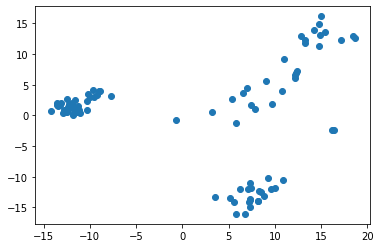

Åland Islands (1, 96) <class 'numpy.ndarray'>
American Samoa (1, 96) <class 'numpy.ndarray'>
Andorra (1, 96) <class 'numpy.ndarray'>
Anguilla (1, 96) <class 'numpy.ndarray'>
Antigua & Barbuda (1, 96) <class 'numpy.ndarray'>


In [49]:
# Transform the training set
X_transformed = pca_model.transform(X)
print("The shape of the transformed training set is", X_transformed.shape)

# Plot the transformed training set for the first two components
import matplotlib.pyplot as plt
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.show()

pca_applied_outputs = {}
for k, v in results.items():
    pca_applied_outputs[k] = pca_model.transform(v.reshape(1, -1))

for k,v in list(pca_applied_outputs.items())[:5]:
    print(k, v.shape, type(v))

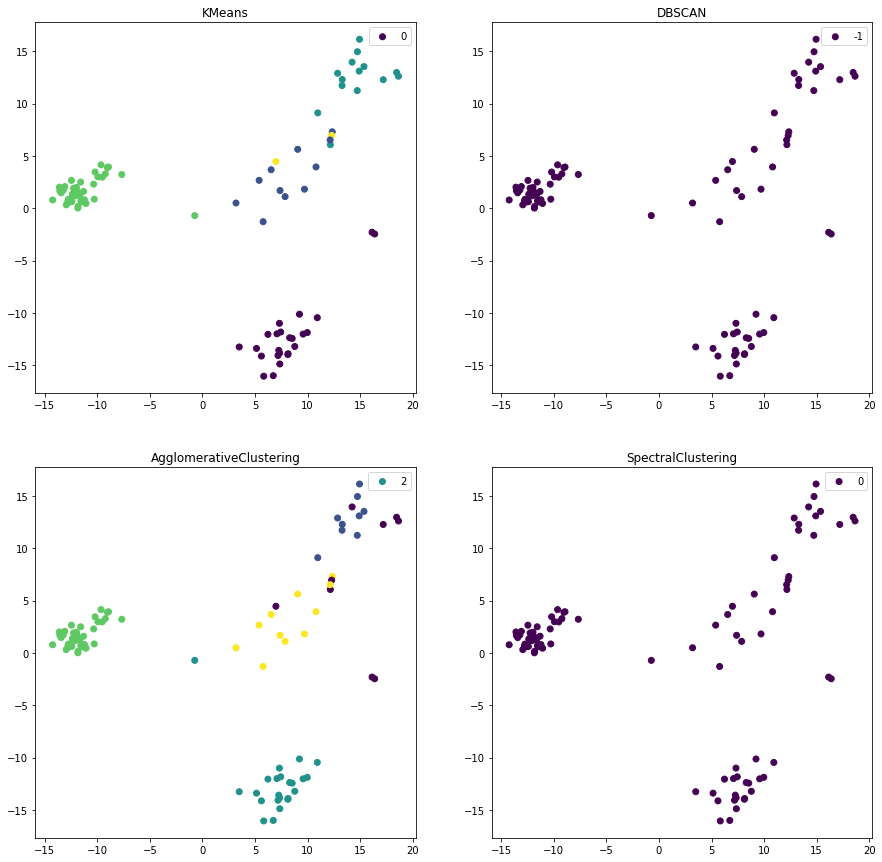

In [115]:
# We can find clustering of the countries by their PCA applied vectors
# using KMeans, DBSCAN, AgglomerativeClustering, and SpectralClustering
# and plot them 
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering

algorithms = [KMeans(n_clusters=5), DBSCAN(eps=0.5), AgglomerativeClustering(n_clusters=5), SpectralClustering(n_clusters=5)]
ax, fig = plt.subplots(2,2, figsize=(15,15))
for i, algorithm in enumerate(algorithms):
    algorithm.fit(X_transformed)
    plt.subplot(2,2,i+1)
    plt.scatter(X_transformed[:,0], X_transformed[:,1], c=algorithm.labels_)
    plt.title(algorithm.__class__.__name__)

In [119]:
# Compare which clustering algorithm is the best using multiple metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
for algorithm in algorithms:
    for metric in [silhouette_score, calinski_harabasz_score, davies_bouldin_score]:
        try:
            print(algorithm.__class__.__name__, metric.__name__, metric(X_transformed, algorithm.labels_))
        except Exception as e:
            continue

KMeans silhouette_score 0.18525274
KMeans calinski_harabasz_score 10.18218690102653
KMeans davies_bouldin_score 2.1459642006839754
AgglomerativeClustering silhouette_score 0.17823976
AgglomerativeClustering calinski_harabasz_score 10.378444069786458
AgglomerativeClustering davies_bouldin_score 2.1701746117655425


We can see KMeans performs better in silhouette score than AgglomerativeClustering, however, AgglomerativeClustering performs better in the Calinski-Harabasz score by a small margin. In our case, we will use AgglomerativeClustering as it is more computationally efficient and the score difference is not significant.

In [121]:
# We will explore the countries that are clustered together
# by the clustering algorithm
from collections import defaultdict
clustered_countries = defaultdict(list)
for i, label in enumerate(AgglomerativeClustering(n_clusters=5).fit(X_transformed).labels_):
    clustered_countries[label].append(list(results.keys())[i])

for k,v in clustered_countries.items():
    print(k, v)
    

2 ['Åland Islands', 'Anguilla', 'Bosnia & Herzegovina', 'British Virgin Islands', 'Central African Republic', 'Curaçao', 'Eswatini', 'Faroe Islands', 'French Polynesia', 'French Southern Territories', 'Isle of Man', 'Mauritania', 'Montserrat', 'Northern Mariana Islands', 'Papua New Guinea', 'Réunion', 'St. Helena', 'St. Lucia', 'St. Martin', 'Tokelau', 'Trinidad & Tobago', 'Tuvalu', 'United Arab Emirates']
3 ['American Samoa', 'Andorra', 'Aruba', 'Burkina Faso', 'Cape Verde', 'Caribbean Netherlands', 'Cayman Islands', 'Christmas Island', 'Comoros', 'Cook Islands', 'Costa Rica', 'Czechia', 'Dominica', 'Dominican Republic', 'El Salvador', 'Equatorial Guinea', 'Falkland Islands', 'French Guiana', 'Lesotho', 'Marshall Islands', 'Mayotte', 'Micronesia', 'Nauru', 'New Caledonia', 'New Zealand', 'Niue', 'Norfolk Island', 'North Korea', 'North Macedonia', 'Palau', 'Palestinian Territories', 'Puerto Rico', 'San Marino', 'Saudi Arabia', 'Sierra Leone', 'Solomon Islands', 'South Africa', 'South K

We can see some clustering the results above. Now we proceed to find the cosine similarlity between the vectors of the country names. 

In [56]:
# Find cosine similarity between the outputs
from scipy.spatial.distance import cosine
import numpy as np
from itertools import combinations

def cosine_similarity(a, b):
    return 1 - cosine(a, b)


def find_similarities_between_vectors(output, similarity_measure=cosine_similarity, commutative=False):
    """
    :param output: a dictionary  of vectors with name as key and vector as value
    :param similarity_measure: a function that takes two vectors 
    and returns a similarity score, default is cosine similarity.
    :param commutative: if True, the similarity measure is commutative and only half the combinations are calculated. 

    :return a dictionary of with key as country pairs and 
    value as the output of the model
    """
    similarities = {}
    for k,v in pca_applied_outputs.items():
        for k2,v2 in pca_applied_outputs.items():
            if k != k2:
                similarities[(k,k2)] = similarity_measure(v, v2)
            if commutative and k == k2:
                break
    return similarities


cosine_similarities = find_similarities_between_vectors(pca_applied_outputs, commutative=True)

            

Now we will explore this further by looking at the cosine similarity between the vectors of the country names.

In [57]:
# Countries that are the most similar to each other
import operator
sorted_cosine_similarities = sorted(cosine_similarities.items(), key=operator.itemgetter(1), reverse=True)
print("The most similar countries are", sorted_cosine_similarities[:10])

The most similar countries are [(('Solomon Islands', 'Marshall Islands'), 0.7676256895065308), (('South Korea', 'North Korea'), 0.7383821606636047), (('Congo - Kinshasa', 'Congo - Brazzaville'), 0.7356618642807007), (('St. Lucia', 'St. Helena'), 0.7305314540863037), (('Marshall Islands', 'Cook Islands'), 0.7168470025062561), (('Solomon Islands', 'Cook Islands'), 0.7080401182174683), (('Macao SAR China', 'Hong Kong SAR China'), 0.6800421476364136), (('St. Martin', 'St. Lucia'), 0.6776474714279175), (('Norfolk Island', 'Christmas Island'), 0.6699836850166321), (('Puerto Rico', 'Costa Rica'), 0.6395531296730042)]


In [59]:
# top 10 most dissimilar countries
print("The most dissimilar countries are", sorted_cosine_similarities[-10:])

The most dissimilar countries are [(('United States', 'Guadeloupe'), -0.3043801486492157), (('Sri Lanka', 'Anguilla'), -0.30627259612083435), (('St. Helena', 'Micronesia'), -0.30670246481895447), (('North Macedonia', 'Curaçao'), -0.3094418942928314), (('St. Helena', 'Solomon Islands'), -0.31401699781417847), (('United Arab Emirates', 'New Caledonia'), -0.3194366991519928), (('Mauritania', 'Cayman Islands'), -0.3216574788093567), (('United Arab Emirates', 'Palau'), -0.32564491033554077), (('Burkina Faso', 'British Virgin Islands'), -0.32890281081199646), (('French Polynesia', 'Cayman Islands'), -0.3475682735443115)]


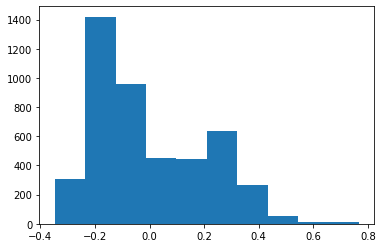

In [58]:
# plot the distribution of the cosine similarities
plt.hist(list(cosine_similarities.values()))
plt.show()

One can repeat the process for different simialrity score and dimensional reduction techniques.

We can see that the cosine similarity between the vectors of the country names are not very high. 

## Food exploration

In the similar manner as above we can explore the food dataset. 

## Language exploration

In the similar manner as above we can explore the language dataset. 

In [60]:
try:
    from langcodes import *
except ImportError:
    !pip install langcodes
    from langcodes import *

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [86]:
def get_bert_outputs(inputs):
    """
    :param inputs: list of strings
    :return: a dictionary with key as the input and
    value as tensors of shape (batch_size, seq_len, hidden_size)
    """
    from transformers import BertTokenizer, BertModel
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained("bert-base-uncased")
    model.eval()
    output = [(input,model(**encoded_input)) for input, encoded_input in zip(inputs, [tokenizer(i, return_tensors='pt') for i in inputs])]
    return dict(output)


assert get_bert_outputs(['hello', 'world'])['hello'][0].shape == (1, 3, 768)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [94]:
def padding_the_output(bert_output, padding_value):
    """
    :param bert_output: a dictionary with key as the input and
    value as tensors of shape (batch_size, seq_len, hidden_size)
    :param padding_value: the value to use

    :return: a dictionary with key as the input and value as the output of the dimension reduction model
    """
    MAX_LEN = max([v[0].shape[1] for k,v in bert_output.items()])
    return {k:np.pad(v[0].detach().numpy().flatten(), (0, MAX_LEN - v[0].shape[1]), 'constant', constant_values=padding_value) for k,v in bert_output.items()}    
assert padding_the_output(get_bert_outputs(['hello', 'world']), 0)['hello'].shape == padding_the_output(get_bert_outputs(['hello', 'world']), 0)['world'].shape

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.tr

## More datasets 

We are going to explore the same process for the all the languages, music and food datasets.